In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import string

import nltk
from nltk.tokenize import TreebankWordTokenizer, word_tokenize
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve, auc

import mglearn

from IPython.lib.display import Audio


In [2]:
df = pd.read_csv('data/tweet_data.csv')

In [3]:
def clean_text(some_text):
    """
    Cleans text for NLP analysis
    Input:
    Output: 
    """
    some_text = some_text.lower()
    
    # links
    some_text = re.sub(r"http\S+","", some_text)
    
    # hashtags
    some_text = re.sub(r"#[A-Za-z0-9_]+","", some_text)
    
    # At's
    some_text = re.sub(r"@[A-Za-z0-9_]+","", some_text)
    
    # Numbers
    some_text = re.sub(r"[0-9]+", "", some_text)
    
    # Punctuation
    some_text = re.sub(r"[()!?.,]"), " ", some_text
    
#     return 

In [4]:
df.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
0,1070867471245164544,2018-12-07 02:27:55,-1,-1,98,False,True,False,64,https://pbs.twimg.com/media/Dtx8SiIWkAImVsb.jpg,34,-1,The immediate impulse for an alliance of the E...,Business,23464532,5988062,The Economist,NaN
1,1070868017888837633,2018-12-07 02:30:05,-1,-1,13,False,True,False,10,https://pbs.twimg.com/media/Dtx8yTyW4AEciqP.jpg,3,-1,America's economy is flashing some warning sig...,Business,1732809,16184358,CNN Business,NaN
2,1070868012864028673,2018-12-07 02:30:04,-1,-1,12,False,True,False,8,NaN,4,-1,Lyft files for what is expected to be one of t...,Business,2253989,25053299,FORTUNE,NaN
3,1070867995239555075,2018-12-07 02:30:00,-1,-1,5,False,True,False,4,NaN,1,-1,"Exporters still waiting to get Rs 6,000 crore ...",Business,1704056,43855487,Business Standard,NaN
4,1070867995205885952,2018-12-07 02:30:00,-1,-1,5,False,True,False,2,NaN,3,-1,Ride-hailing firm Lyft races to leave Uber beh...,Business,1997662,15110357,Reuters Business,https://video.twimg.com/amplify_video/10708116...


In [5]:
df['text'][0]

"The immediate impulse for an alliance of the EU's northern states is Brexit https://t.co/nlhUD36hay https://t.co/shwMWpjjuK"

In [6]:
df['text_user'] = df['text']  + " "+ df["usName"]

In [7]:
df['text_user'][2]

'Lyft files for what is expected to be one of the hottest IPOs in 2019 https://t.co/qEjyniazlD FORTUNE'

#### How to save a model

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/

```
import pickle

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size, random_state=seed)
# Fit the model on training set
model = LogisticRegression()
model.fit(X_train, Y_train)
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)
```

In [8]:
df_business = df[df['topicName']=='Business']

In [9]:
df_business.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl,text_user
0,1070867471245164544,2018-12-07 02:27:55,-1,-1,98,False,True,False,64,https://pbs.twimg.com/media/Dtx8SiIWkAImVsb.jpg,34,-1,The immediate impulse for an alliance of the E...,Business,23464532,5988062,The Economist,NaN,The immediate impulse for an alliance of the E...
1,1070868017888837633,2018-12-07 02:30:05,-1,-1,13,False,True,False,10,https://pbs.twimg.com/media/Dtx8yTyW4AEciqP.jpg,3,-1,America's economy is flashing some warning sig...,Business,1732809,16184358,CNN Business,NaN,America's economy is flashing some warning sig...
2,1070868012864028673,2018-12-07 02:30:04,-1,-1,12,False,True,False,8,NaN,4,-1,Lyft files for what is expected to be one of t...,Business,2253989,25053299,FORTUNE,NaN,Lyft files for what is expected to be one of t...
3,1070867995239555075,2018-12-07 02:30:00,-1,-1,5,False,True,False,4,NaN,1,-1,"Exporters still waiting to get Rs 6,000 crore ...",Business,1704056,43855487,Business Standard,NaN,"Exporters still waiting to get Rs 6,000 crore ..."
4,1070867995205885952,2018-12-07 02:30:00,-1,-1,5,False,True,False,2,NaN,3,-1,Ride-hailing firm Lyft races to leave Uber beh...,Business,1997662,15110357,Reuters Business,https://video.twimg.com/amplify_video/10708116...,Ride-hailing firm Lyft races to leave Uber beh...


In [10]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164602 entries, 0 to 785869
Data columns (total 19 columns):
tweetID       164602 non-null int64
crDate        164602 non-null object
edInput       164602 non-null int64
editor        164602 non-null int64
engages       164602 non-null int64
isApproved    164602 non-null bool
isEdNeed      164602 non-null bool
isRT          164602 non-null bool
likes         164602 non-null int64
photoUrl      20134 non-null object
retweets      164602 non-null int64
rtUsID        164602 non-null int64
text          164602 non-null object
topicName     164602 non-null object
usFlwrs       164602 non-null int64
usID          164602 non-null int64
usName        164602 non-null object
videoUrl      25446 non-null object
text_user     164602 non-null object
dtypes: bool(3), int64(9), object(7)
memory usage: 21.8+ MB


In [11]:
df_business = df_business.drop(['photoUrl', 'videoUrl'], axis = 1)

In [12]:
df_business['edInput'].value_counts()

-1    123309
 1     17836
 2     12188
 4     10721
 3       548
Name: edInput, dtype: int64

In [13]:
# https://www.statology.org/pandas-drop-rows-with-value/
df_business = df_business[df_business['edInput'].isin([-1, 3, 4])==False]

In [14]:
df_business['edInput'].value_counts()

1    17836
2    12188
Name: edInput, dtype: int64

In [15]:
df_business['label'] = df_business['edInput'].apply(
    lambda label: 1 if label == 1 else 0)

In [16]:
df_business.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,text_user,label
12252,1072758722315862021,2018-12-12 07:43:04,2,5001,9618,False,True,True,5771,3847,621523,UK Prime Minister Theresa May will face a vote...,Business,38564612,5402612,BBC Breaking News,UK Prime Minister Theresa May will face a vote...,0
14042,1072959907958276096,2018-12-12 21:02:31,2,5001,10388,False,True,True,6977,3411,621523,UK PM Theresa May wins confidence vote with 20...,Business,38567131,5402612,BBC Breaking News,UK PM Theresa May wins confidence vote with 20...,0
16954,1073329348755767303,2018-12-13 21:30:32,2,5001,6734,False,True,True,4467,2267,3108351,The probe of the inaugural fund partly arises ...,Business,57108,705706292,Rebecca Ballhaus,The probe of the inaugural fund partly arises ...,0
18004,1073499538659393536,2018-12-14 08:46:49,1,5001,6914,True,True,True,5402,1512,621523,The week Brexit hit the brick wall : Commons ...,Business,879928,25984418,Nick Robinson,The week Brexit hit the brick wall : Commons ...,1
18396,1073542862573371392,2018-12-14 11:38:58,2,5001,6269,False,True,True,4610,1659,621523,Have watched these kinds of pictures looking f...,Business,888862,61183568,Laura Kuenssberg,Have watched these kinds of pictures looking f...,0


In [17]:
df_business['label'].value_counts()

1    17836
0    12188
Name: label, dtype: int64

In [18]:
df_business_label = df_business[['text', 'label', 'engages', 'likes', 'retweets', 'usFlwrs', 'usName']]

In [19]:
df_business_label.head()

,text,label,engages,likes,retweets,usFlwrs,usName
12252,UK Prime Minister Theresa May will face a vote...,0,9618,5771,3847,38564612,BBC Breaking News
14042,UK PM Theresa May wins confidence vote with 20...,0,10388,6977,3411,38567131,BBC Breaking News
16954,The probe of the inaugural fund partly arises ...,0,6734,4467,2267,57108,Rebecca Ballhaus
18004,The week Brexit hit the brick wall : Commons ...,1,6914,5402,1512,879928,Nick Robinson
18396,Have watched these kinds of pictures looking f...,0,6269,4610,1659,888862,Laura Kuenssberg


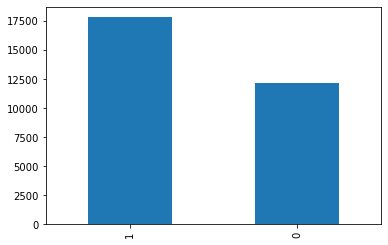

In [20]:
df_business_label['label'].value_counts().plot(kind='bar')

In [21]:
# nltk.download('words')
words = set(nltk.corpus.words.words())

In [22]:
def preprocess_text(my_text):
    """
    Take in column (pandas series) of text and return 'cleaned' text
    
    Input: column of text
    Output: column of cleaned text
    """
    new_text = []
    
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
    
    alpha_lower = my_text.map(alphanumeric).map(punc_lower)
    
    for item in alpha_lower:
        new_text.append(" ".join(w for w in nltk.wordpunct_tokenize(item) if w.lower() in words or not w.isalpha()))
        
    return new_text

In [23]:
df_business_label['clean_text'] = preprocess_text(df_business_label['text'])

e:\Users\user\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
df_business_label

,text,label,engages,likes,retweets,usFlwrs,usName,clean_text
12252,UK Prime Minister Theresa May will face a vote...,0,9618,5771,3847,38564612,BBC Breaking News,prime minister may will face a vote of no conf...
14042,UK PM Theresa May wins confidence vote with 20...,0,10388,6977,3411,38567131,BBC Breaking News,may confidence vote with out of tory supportin...
16954,The probe of the inaugural fund partly arises ...,0,6734,4467,2267,57108,Rebecca Ballhaus,the probe of the inaugural fund partly out of ...
18004,The week Brexit hit the brick wall : Commons ...,1,6914,5402,1512,879928,Nick Robinson,the week hit the brick wall commons won ’ t ac...
18396,Have watched these kinds of pictures looking f...,0,6269,4610,1659,888862,Laura Kuenssberg,have watched these of looking for body languag...
...,...,...,...,...,...,...,...,...
785779,This bouquet of roses is completely edible htt...,0,431,321,110,214469,FOOD INSIDER,this bouquet of is completely edible t
785809,This fancy McDonald's has a handwashing statio...,0,699,504,195,214487,FOOD INSIDER,this fancy s a station and real silverware 🍴 t
785813,🚨 Spoilers ahead 🚨\nFinished #StrangerThings? ...,0,135,101,34,16441,Kim Renfro,🚨 ahead 🚨 finished great let s dive into some ...
785829,These cakes are topped with yogurt 🎂 https://t...,0,1892,1412,480,214530,FOOD INSIDER,these are topped with 🎂 t


In [25]:
more_words = ['rt', 'rts', 'retweet']
s_words = set().union(stopwords.words('english'), more_words)

In [26]:
df_business_label['processed_text'] = df_business_label['text'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z \t])',' ')\
          .str.replace(' +',' ')\
          .apply(lambda x: [i for i in x.split() if not i in s_words])

e:\Users\user\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
df_business_label['processed_text'] = df_business_label['processed_text'].apply(" ".join)

e:\Users\user\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
df_business_label['processed_text']

12252     uk prime minister theresa may face vote confid...
14042     uk pm theresa may wins confidence vote 200 317...
16954     probe inaugural fund partly arises materials s...
18004     week brexit hit brick wall commons accept may ...
18396     watched kinds pictures looking body language b...
                                ...                        
785779                      bouquet roses completely edible
785809    fancy mcdonald handwashing station real silver...
785813    spoilers ahead finished strangerthings great l...
785829                                  cakes topped yogurt
785854                              team shake shack team n
Name: processed_text, Length: 30024, dtype: object

In [29]:
df_business_label['processed_text'].duplicated().value_counts()

False    27854
True      2170
Name: processed_text, dtype: int64

In [30]:
bool_series = df_business_label['processed_text'].duplicated()

In [70]:
df_processed = df_business_label[~bool_series]

In [71]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27854 entries, 12252 to 785854
Data columns (total 9 columns):
text              27854 non-null object
label             27854 non-null int64
engages           27854 non-null int64
likes             27854 non-null int64
retweets          27854 non-null int64
usFlwrs           27854 non-null int64
usName            27854 non-null object
clean_text        27854 non-null object
processed_text    27854 non-null object
dtypes: int64(5), object(4)
memory usage: 2.1+ MB


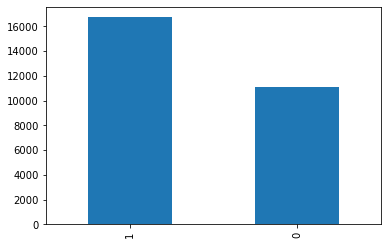

In [72]:
df_processed['label'].value_counts().plot(kind='bar')

In [73]:
df_processed.head()

,text,label,engages,likes,retweets,usFlwrs,usName,clean_text,processed_text
12252,UK Prime Minister Theresa May will face a vote...,0,9618,5771,3847,38564612,BBC Breaking News,prime minister may will face a vote of no conf...,uk prime minister theresa may face vote confid...
14042,UK PM Theresa May wins confidence vote with 20...,0,10388,6977,3411,38567131,BBC Breaking News,may confidence vote with out of tory supportin...,uk pm theresa may wins confidence vote 200 317...
16954,The probe of the inaugural fund partly arises ...,0,6734,4467,2267,57108,Rebecca Ballhaus,the probe of the inaugural fund partly out of ...,probe inaugural fund partly arises materials s...
18004,The week Brexit hit the brick wall : Commons ...,1,6914,5402,1512,879928,Nick Robinson,the week hit the brick wall commons won ’ t ac...,week brexit hit brick wall commons accept may ...
18396,Have watched these kinds of pictures looking f...,0,6269,4610,1659,888862,Laura Kuenssberg,have watched these of looking for body languag...,watched kinds pictures looking body language b...


In [74]:
df_processed['text_user'] = df_processed['clean_text']  + " "+ df["usName"]

e:\Users\user\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [75]:
df_processed['text_user'][12252]

'prime minister may will face a vote of no confidence in her leadership later on t BBC Breaking News'

In [76]:
df_processed = df_processed.reset_index(drop=True)

In [77]:
df_processed.head()

,text,label,engages,likes,retweets,usFlwrs,usName,clean_text,processed_text,text_user
0,UK Prime Minister Theresa May will face a vote...,0,9618,5771,3847,38564612,BBC Breaking News,prime minister may will face a vote of no conf...,uk prime minister theresa may face vote confid...,prime minister may will face a vote of no conf...
1,UK PM Theresa May wins confidence vote with 20...,0,10388,6977,3411,38567131,BBC Breaking News,may confidence vote with out of tory supportin...,uk pm theresa may wins confidence vote 200 317...,may confidence vote with out of tory supportin...
2,The probe of the inaugural fund partly arises ...,0,6734,4467,2267,57108,Rebecca Ballhaus,the probe of the inaugural fund partly out of ...,probe inaugural fund partly arises materials s...,the probe of the inaugural fund partly out of ...
3,The week Brexit hit the brick wall : Commons ...,1,6914,5402,1512,879928,Nick Robinson,the week hit the brick wall commons won ’ t ac...,week brexit hit brick wall commons accept may ...,the week hit the brick wall commons won ’ t ac...
4,Have watched these kinds of pictures looking f...,0,6269,4610,1659,888862,Laura Kuenssberg,have watched these of looking for body languag...,watched kinds pictures looking body language b...,have watched these of looking for body languag...


In [78]:
X = df_processed['text_user'].to_numpy()
y = df_processed['label'].to_numpy()

In [79]:
X.shape

(27854,)

In [80]:
X[:5]

array(['prime minister may will face a vote of no confidence in her leadership later on t BBC Breaking News',
       'may confidence vote with out of tory supporting her to stay on as leader t t BBC Breaking News',
       'the probe of the inaugural fund partly out of in the raid a conversation between an ex adviser in which she expressed concern about the fund s spending t Rebecca Ballhaus',
       'the week hit the brick wall commons won ’ t accept may ’ s deal won ’ t change leader eu won ’ t change may ’ s deal nothing plan b anyone Nick Robinson',
       'have watched these of looking for body language of times have never seen anything as tense and angry as this t Laura Kuenssberg'],
      dtype=object)

In [81]:
y.shape

(27854,)

In [82]:
y[:5]

array([0, 0, 0, 1, 0], dtype=int64)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [84]:
X_train

array(['a privately funded space probe while to land on the moon t Bloomberg',
       'you can actually learn a lot from the on your hair t Business Insider',
       'musk will make as many as this year the lower end of the range t Bloomberg',
       ..., 'have we peak t economics technology t World Economic Forum',
       'alcohol and coffee can dehydrate you on long t Business Insider',
       'the last word at the by saying he to “ restore the soul of our nation ” he he also to unite the country and bring back the dignity of the middle class t t Bloomberg'],
      dtype=object)

In [119]:
X_train.shape

(18662,)

In [86]:
y_train[:100]

array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

In [87]:
print("Samples per class (training): {}".format(np.bincount(y_train)))

Samples per class (training): [ 7497 11165]


In [88]:
print("Number of documents in test data: {}".format(len(X_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))

Number of documents in test data: 9192
Samples per class (test): [3630 5562]


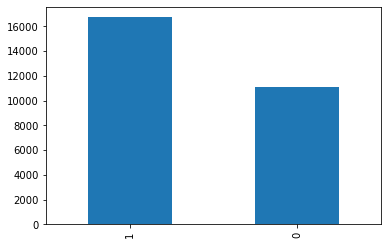

In [89]:
df_processed['label'].value_counts().plot(kind='bar')

In [90]:
vect = CountVectorizer().fit(X_train)

In [91]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 10331
First 20 features:
['aaron', 'abandon', 'abandoned', 'abbey', 'abbreviation', 'abc', 'abdication', 'abduction', 'abelson', 'abigail', 'ability', 'ablan', 'able', 'abnormal', 'abnormally', 'aboard', 'abolish', 'abolition', 'aborted', 'abortion']
Features 20010 to 20030:
[]
Every 2000th feature:
['aaron', 'convoy', 'goose', 'needs', 'selling', 'warn']


In [92]:
X_train_vect = vect.transform(X_train)
print("X_train:\n{}".format(repr(X_train_vect)))

X_train:
<18662x10331 sparse matrix of type '<class 'numpy.int64'>'
	with 250518 stored elements in Compressed Sparse Row format>


In [93]:
scores = cross_val_score(LogisticRegression(max_iter=5000), X_train_vect, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.78


In [94]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid.fit(X_train_vect, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.79
Best parameters:  {'C': 0.1}


In [95]:
X_test_vect = vect.transform(X_test)
print("Test score: {:.2f}".format(grid.score(X_test_vect, y_test)))

Test score: 0.79


#### Count Vectorizer: min_df=5

In [96]:
vect_min5 = CountVectorizer(min_df=5).fit(X_train)
X_train_vect_min5 = vect_min5.transform(X_train)
print("X_train with min_df: {}".format(repr(X_train_vect_min5)))

X_train with min_df: <18662x3948 sparse matrix of type '<class 'numpy.int64'>'
	with 239019 stored elements in Compressed Sparse Row format>


In [97]:
feature_names_min5 = vect_min5.get_feature_names()

print("First 50 features:\n{}".format(feature_names_min5[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names_min5[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names_min5[::700]))

First 50 features:
['abandon', 'abandoned', 'abigail', 'ability', 'able', 'aboard', 'abortion', 'about', 'above', 'abramowicz', 'abroad', 'abruptly', 'absolute', 'absolutely', 'absorb', 'abu', 'abuse', 'academy', 'accept', 'acceptance', 'access', 'accident', 'accidentally', 'accomplish', 'accord', 'according', 'account', 'accountability', 'accountable', 'accounting', 'accused', 'achieve', 'acknowledge', 'acquire', 'acquisition', 'acre', 'across', 'act', 'acting', 'action', 'active', 'actively', 'activist', 'activity', 'actor', 'actress', 'actual', 'actually', 'ad', 'adam']
Features 20010 to 20030:
[]
Every 700th feature:
['abandon', 'commit', 'fleet', 'manila', 'regional', 'them']


In [98]:
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid.fit(X_train_vect_min5, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.79


### TF-IDF Vectorizer

In [99]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(max_iter=5000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.78


In [100]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset:
X_train_vect = vectorizer.transform(X_train)
# find maximum value for each of the features over dataset:
max_value = X_train_vect.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['bloomberg' 'inc' 'harvard' 'biz' 'via' 'reuters' 'according' 'even'
 'know' 'breaking' 'tictoc' 'industry' 'while' 'through' 'second' 'ever'
 'record' 'north' 'without' 'real']
Features with highest tfidf: 
['sector' 'artificial' 'you' 'great' 'we' 'census' 'walk' 'like' 'field'
 'am' 'dish' 'waiting' 'spring' 'metal' 'dust' 'capital' 'fired' 'she'
 'best' 'network']


In [101]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'bloomberg' 'to' 'insider' 'business' 'of' 'in' 'and' 'is' 'for'
 'on' 'it' 'are' 'that' 'you' 'with' 'this' 'inc' 'at' 'from' 'trump' 'be'
 'as' 'your' 'how' 'more' 'here' 'an' 'review' 'by' 'harvard' 'new' 'its'
 'will' 'can' 'have' 'after' 'about' 'what' 'biz' 'but' 'china' 'his'
 'than' 'their' 'just' 'world' 'these' 'one' 'he' 'people' 'if' 'they'
 'up' 'via' 'why' 'was' 'over' 'not' 'out' 'year' 'million' 'most' 'may'
 'billion' 'first' 'who' 'when' 'could' 'all' 'into' 'do' 'time' 'make'
 'we' 'president' 'get' 'company' 'like' 're' 'trade' 'some' 'now' 'so'
 'no' 'top' 'or' 'next' 'reuters' 'there' 'work' 'don' 'best' 'said' 'us'
 'two' 'food' 'biggest' 'them' 'been']


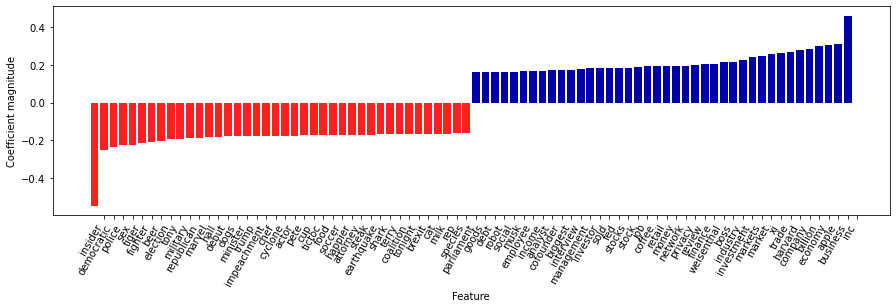

In [102]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40)

In [103]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
# param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
#               "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

param_grid = {'logisticregression__C': [0.1, 1, 10],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.79
Best parameters:
{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 1)}


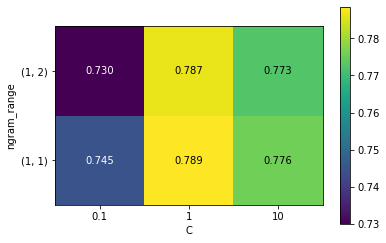

In [104]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 2).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

(-22.0, 22.0)

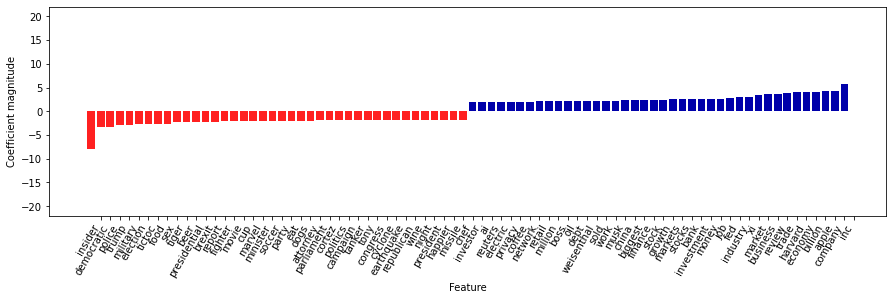

In [105]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
plt.ylim(-22, 22)

In [106]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[5825 1672]
 [1261 9904]]
F-Measure: 0.871


In [107]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[2567 1063]
 [ 850 4712]]
F-Measure: 0.831


In [108]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      3630
           1       0.82      0.85      0.83      5562

    accuracy                           0.79      9192
   macro avg       0.78      0.78      0.78      9192
weighted avg       0.79      0.79      0.79      9192



### Random Forest



In [109]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), RandomForestClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__ngram_range": [(1, 1), (1, 2)],
              "randomforestclassifier__n_estimators": [800, 1000]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.77
Best parameters:
{'randomforestclassifier__n_estimators': 1000, 'tfidfvectorizer__ngram_range': (1, 1)}


In [110]:
framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

RF hyperparameter tuning


https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [112]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__min_df": [1,5],
              "randomforestclassifier__n_estimators": [1200, 1400],
              "randomforestclassifier__min_samples_leaf": [0.5, 5],
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.77
Best parameters:
{'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 1200, 'tfidfvectorizer__min_df': 1}


In [123]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__min_df": [1],
              "randomforestclassifier__n_estimators": [1200],
              "randomforestclassifier__min_samples_leaf": [5],
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.77
Best parameters:
{'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 1200, 'tfidfvectorizer__min_df': 1}


In [124]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('Train F-Measure: %.3f' % score_train)

[[5396 2101]
 [1199 9966]]
Train F-Measure: 0.858


In [125]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('Test F-Measure: %.3f' % score_test)

[[2370 1260]
 [ 810 4752]]
Test F-Measure: 0.821


In [126]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.75      0.65      0.70      3630
           1       0.79      0.85      0.82      5562

    accuracy                           0.77      9192
   macro avg       0.77      0.75      0.76      9192
weighted avg       0.77      0.77      0.77      9192



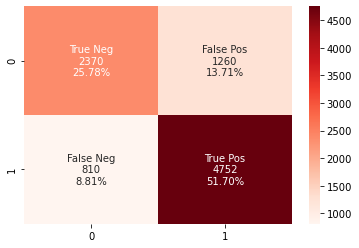

In [127]:
results = confusion_matrix(actual, predicted) 

#heatmap for confusion matrix

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                results.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     results.flatten()/np.sum(results)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(results, annot=labels, fmt='', cmap='Reds')

In [128]:
framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [113]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"randomforestclassifier__n_estimators": [1100, 1200],
              "randomforestclassifier__max_features": [75, 125],
              "randomforestclassifier__min_samples_leaf": [3, 5],
              "randomforestclassifier__max_depth": [7, 9]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.61
Best parameters:
{'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 125, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__n_estimators': 1100}


In [129]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"randomforestclassifier__n_estimators": [1100],
              "randomforestclassifier__max_features": [125]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.77
Best parameters:
{'randomforestclassifier__max_features': 125, 'randomforestclassifier__n_estimators': 1100}


### XGBoost

In [114]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), XGBClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"xgbclassifier__n_estimators": [1400, 1500],
              "xgbclassifier__scale_pos_weight": [1, 3]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.77
Best parameters:
{'xgbclassifier__n_estimators': 1400, 'xgbclassifier__scale_pos_weight': 1}


In [115]:
framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [121]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('Train F-Measure: %.3f' % score_train)

[[6156 1341]
 [1211 9954]]
Train F-Measure: 0.886


In [122]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('Test F-Measure: %.3f' % score_test)

[[2599 1031]
 [ 951 4611]]
Test F-Measure: 0.823


In [118]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      3630
           1       0.82      0.83      0.82      5562

    accuracy                           0.78      9192
   macro avg       0.77      0.77      0.77      9192
weighted avg       0.78      0.78      0.78      9192



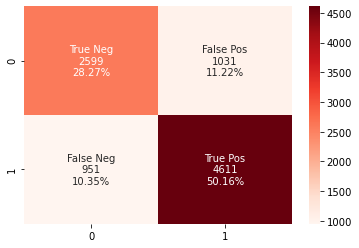

In [120]:
results = confusion_matrix(actual, predicted) 

#heatmap for confusion matrix

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                results.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     results.flatten()/np.sum(results)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(results, annot=labels, fmt='', cmap='Reds')